# GeoTA Project : Pixel Classifier
---
* Abhishikth Boda  : S20210010044 <br>
* Poojyanth Reddy  : S20210010137 <br>
* Tarun Patibandla : S20210010172
---
The program below makes use of raster and vector files to classify various pixels into classes based on input "layers".

<a target="_blank" href="https://colab.research.google.com/github/poojyanth/CSSA/blob/main/geota_project.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Imports

In [ ]:
import rasterio
from rasterio.plot import show
from rasterio.plot import adjust_band, show
from rasterio.features import rasterize
import geopandas as gpd
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing, verifying and visualizing raster data

In [ ]:
# Checking if the imports are correct
with rasterio.open('./CSSA/Poojyanth/stacked/L3-NH43X01-096-051-05Apr19-BAN_stack_raster.tif') as src:
    # Get the number of bands in the raster file
    num_bands = src.count

    print(f'The GeoTIFF file has {num_bands} band(s).')

The GeoTIFF file has 4 band(s).


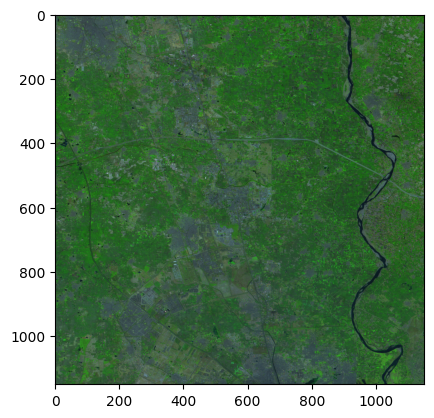

In [ ]:
# Here, we explore the central part of delhi
with rasterio.open('./CSSA/Poojyanth/stacked/L3-NH43X01-096-051-05Apr19-BAN_stack_raster.tif') as src:

    # Here, adjust_band is used for good visualization
    b1 = adjust_band(src.read(2))
    b2 = adjust_band(src.read(3))
    b3 = adjust_band(src.read(4))


    # false color img with the above 3 bands
    false_color_image = [b3, b2, b1]

    show(false_color_image)

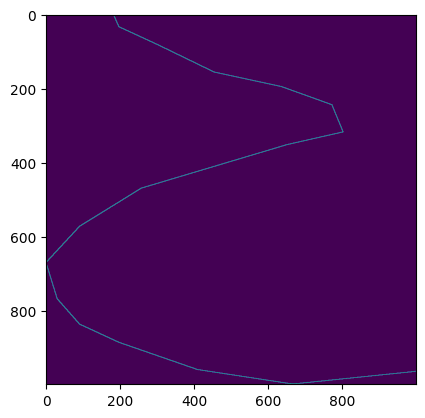

<Axes: >

In [ ]:
# Code to rasterize vector images.
vector_data_water = gpd.read_file(r'./waterbody.shp')

raster_shape = (1000, 1000)
transform = rasterio.transform.from_bounds(*vector_data_water.total_bounds, *raster_shape)

rasterized_waterbodies = rasterize(
    shapes=vector_data_water.geometry,
    out_shape=raster_shape,
    transform=transform,
    fill=0,
    all_touched=True,
    dtype='uint8'
)

show(rasterized_waterbodies)

In [ ]:
rasterized_waterbodies.shape

(1000, 1000)

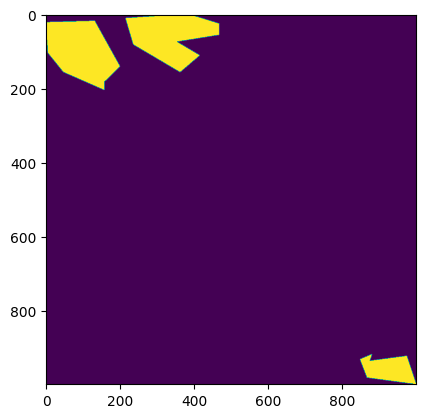

<Axes: >

In [ ]:
vector_data_buildings = gpd.read_file('./buildings.shp')

raster_shape = (1000, 1000)
transform = rasterio.transform.from_bounds(*vector_data_buildings.total_bounds, *raster_shape)

rasterized_buildings = rasterize(
    shapes=vector_data_buildings.geometry,
    out_shape=raster_shape,
    transform=transform,
    fill=0,
    all_touched=True,
    dtype='uint8'
)

show(rasterized_buildings)

In [ ]:

water_bodies = list()

# Here, we define the code to gather spectra of the regions of overlap between the original satellite raster image, and the image containing class information.
with rasterio.open(r'./CSSA/Poojyanth/stacked/L3-NH43X01-096-051-05Apr19-BAN_stack_raster.tif') as src:
    # Read the raster data for img2
    img2_data = rasterized_waterbodies  # Assuming a single band raster, adjust if multiple bands

    # Loop through each pixel in img2 to find corresponding values in img1
    for row in range(img2_data.shape[0]):
        for col in range(img2_data.shape[1]):
            if img2_data[row, col] != 0:  # Check if pixel in img2 is not zero
                # Get the values of all 4 bands in img1 at the same location
                values_img1 = []
                for band in range(1, src.count + 1):
                    band_data = src.read(band)
                    values_img1.append(band_data[row, col])

                if sum(values_img1) != 0:
                    water_bodies.append(
                        {
                            'x' : col,
                            'y' : row,
                            'spectra' : values_img1
                        }
                    )

In [ ]:
# saving the above list of dicts to save time
file_path = './classes/water_data.pickle'

with open(file_path, 'wb') as file:
    pickle.dump(water_bodies, file)

In [ ]:
pickle_file_path = "./classes/water_data.pickle"

# l0oading the earlier saved pickle file
with open(pickle_file_path, 'rb') as file:
    water_bodies = pickle.load(file)


# Converting a list of dicts to just a list of 4-tuples containing spectra
water_bodies = np.array([water_body["spectra"] for water_body in water_bodies])

In [ ]:
def get_mean(data_tuples):
    return np.mean(data_tuples, axis=0) # returns the tuple mean given a numpy array containing all the 4tuple spectra

In [ ]:
mean_waterbodies = get_mean(water_bodies)

In [ ]:
mean_waterbodies

array([122.99884259, 103.95572917, 183.24189815, 132.43055556])

In [ ]:

buildings = list()

# Here, we define the code to gather spectra of the regions of overlap between the original satellite raster image, and the image containing class information.
with rasterio.open(r'./CSSA/Poojyanth/stacked/L3-NH43X01-096-051-05Apr19-BAN_stack_raster.tif') as src:
    # Read the raster data for img2
    img2_data = rasterized_buildings  # Assuming a single band raster, adjust if multiple bands

    # Loop through each pixel in img2 to find corresponding values in img1
    for row in range(img2_data.shape[0]):
        for col in range(img2_data.shape[1]):
            if img2_data[row, col] != 0:  # Check if pixel in img2 is not zero
                # Get the values of all 4 bands in img1 at the same location
                values_img1 = []
                for band in range(1, src.count + 1):
                    band_data = src.read(band)
                    values_img1.append(band_data[row, col])

                if sum(values_img1) != 0:
                    buildings.append(
                        {
                            'x' : col,
                            'y' : row,
                            'spectra' : values_img1
                        }
                    )

In [ ]:
file_path = './classes/buildings_data.pickle'

with open(file_path, 'wb') as file:
    pickle.dump(buildings, file)

In [ ]:
pickle_file_path = "./classes/buildings_data.pickle"

with open(pickle_file_path, 'rb') as file:
    buildings = pickle.load(file)

buildings = np.array([building["spectra"] for building in buildings])

In [ ]:
def get_mean(data_tuples):
    return np.mean(data_tuples, axis=0) # returns the tuple mean given a numpy array containing all the 4tuple spectra


In [ ]:
mean_buildings = get_mean(buildings)

In [ ]:
mean_buildings

array([136.97163146, 121.35820201, 184.34947323, 161.3915431 ])

### Classification and Visualization


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


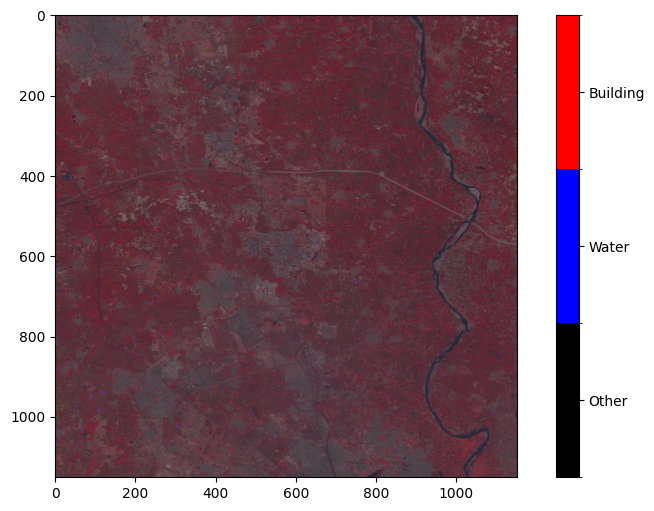

In [ ]:
with rasterio.open(r'./CSSA/Poojyanth/stacked/L3-NH43X01-096-051-05Apr19-BAN_stack_raster.tif') as src:

    raster_data = src.read()

    # Function to calculate Euclidean distance between two tuples
    def euclidean_distance(tuple1, tuple2):
        return np.sqrt(np.sum((np.array(tuple1) - np.array(tuple2)) ** 2))

    # Creating an empty array to store the classified data
    classified_data = np.zeros_like(raster_data[0])

    # Loop over each pixel in the raster data
    for i in range(raster_data.shape[1]):
        for j in range(raster_data.shape[2]):
            pixel_data = tuple(raster_data[:, i, j])
            distance_to_water_body = euclidean_distance(pixel_data, mean_waterbodies)

            distance_to_building = euclidean_distance(pixel_data, mean_buildings)

            if distance_to_water_body > 10 and distance_to_building < 10:
                classified_data[i, j] = 1
            elif distance_to_building > 10 and distance_to_water_body < 10:
                classified_data[i, j] = 2
            else:
                classified_data[i, j] = 0


    # Create a colormap for visualization
    cmap = ListedColormap(['black', 'blue', 'red'])
    bounds = [0, 1, 2, 3]
    norm = BoundaryNorm(bounds, cmap.N)

    # Plot the classified data along with the raster image
    fig, ax = plt.subplots(figsize=(10, 6))
    false_color_image = np.stack([raster_data[2], raster_data[1], raster_data[0]], axis=-1)  # Assuming bands are ordered as (B, G, R)
    ax.imshow(false_color_image)

    # Show the classified data with respective colors
    ax.imshow(classified_data, cmap=cmap, norm=norm, alpha=0.5)

    # Add color bar legend
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, ticks=[0.5, 1.5, 2.5])
    cbar.ax.set_yticklabels(['Other', 'Water', 'Building'])

    plt.show()